In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import spacy
nlp = spacy.load("en_core_web_sm")

# Text Preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

from operator import add
import math
from collections import Counter

import random
from random import sample

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sebastien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sebastien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_rows', 10000)

In [3]:
whole_df = pd.read_csv('/home/sebastien/Documents/Glasgow/Semester2/Text_As_Data/coursework/archive/Reviews.csv')

In [4]:
len(whole_df)

568454

In [5]:
## Shortening the dataset to 10,000 reviews. 
whole_df = pd.read_csv('/home/sebastien/Documents/Glasgow/Semester2/Text_As_Data/coursework/archive/Reviews.csv')
df = whole_df[:10000]

#shuffled_reviews = random.sample(df, k=len(df))

## Split the data into 60% train, 20% validation, 20% testing.

#train_frac = 0.6
#split_idx = int(train_frac * len(shuffled_reviews))
#train_reviews = shuffled_reviews[:split_idx]
#validation_test_reviews = shuffled_reviews[split_idx:]

#valid_test_frac = 0.5
#split_id = int(valid_test_frac * len(validation_test_reviews))
#validation_reviews = validation_test_reviews[:split_id]
#test_reviews = validation_test_reviews[split_id:]


In [6]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [7]:
df.shape

(10000, 10)

In [8]:
#df.head()

In [9]:
df_test = whole_df[20000:45000]

In [10]:
df_test.shape

(25000, 10)

In [11]:
#df_test.head()

In [12]:
df_test.drop(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1, inplace=True)

In [13]:
df_test.loc[df_test['Score'] == 1, 'Sentiment'] = 'Negative'
df_test.loc[df_test['Score'] == 2, 'Sentiment'] = 'Negative'
df_test.loc[df_test['Score'] == 3, 'Sentiment'] = 'Neutral'
df_test.loc[df_test['Score'] == 4, 'Sentiment'] = 'Positive'
df_test.loc[df_test['Score'] == 5, 'Sentiment'] = 'Positive'

In [14]:
df_negative = len(df_test[df_test["Sentiment"]=="Negative"])
print(df_negative)

3788


In [15]:
df_neutral = len(df_test[df_test["Sentiment"]=="Neutral"])
print(df_neutral)

1946


In [16]:
df_positive = len(df_test[df_test["Sentiment"]=="Positive"])
print(df_positive)

19266


In [17]:
# class count
class_count_0, class_count_1, class_count_2 = df_test['Sentiment'].value_counts()

# Separate class
class_0 = df_test[df_test['Sentiment'] == 'Positive']
class_1 = df_test[df_test['Sentiment'] == 'Neutral']
class_2 = df_test[df_test['Sentiment'] == 'Negative']
# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)

class 0: (19266, 4)
class 1: (1946, 4)
class 2: (3788, 4)


In [18]:
#class_0_under = random.sample(class_0, class_count_2)
#rows = random.sample(data, int(len(data)*sample_split))
#test_under = pd.concat([class_0_under, class_2], axis=0)

#print("total class of 0 and 2:",test_under['Sentiment'].value_counts())
# plot the count after under-sampeling
#test_under['Sentiment'].value_counts().plot(kind='bar', title='count (target)')

In [19]:
size = class_count_0 - (10000 - class_count_1 - class_count_2)
size

15000

In [20]:
class_0_short = class_0.drop(class_0.index[range(size)])

In [21]:
class_0_short.shape

(4266, 4)

In [22]:
print('class 0:', class_0_short.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)

class 0: (4266, 4)
class 1: (1946, 4)
class 2: (3788, 4)


In [23]:
frames = [class_0_short, class_1, class_2]
result = pd.concat(frames)

In [24]:
df_test = result.copy()

In [25]:
df_test.shape

(10000, 4)

In [26]:
#df_test.head()

In [27]:
df_test["Text"][:10]

39570    IN THE PAST I HAVE HAD TROUBLE WITH OTHER COMP...
39573    I must admit my purchase was made out of curio...
39574    I discovered Ambrosia custard while in Ireland...
39575    A friend from England ordered this custard for...
39576    This is a very rich version of British "custar...
39577    A delicately flavored custard that is wonderfu...
39578    I do a lot of grocery shopping at a nearby Fre...
39579    This is great over the sponge cake, but also b...
39580    I live in the UK and buy this custard for my s...
39581    Very pleased with this vendor's service.  We h...
Name: Text, dtype: object

In [28]:
#df_test["Text"][0]

In [29]:
#df_test["Text"][1]

In [30]:
#df_test["Text"][2]

In [31]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    #text = ' '.join(words)
    return text.split()

In [32]:
def make_vocabulary(corpus):
    unique_tokens = sorted(set( t for token_list in corpus for t in token_list))
    token_to_id = { v:i for i,v in enumerate(unique_tokens)}
    return token_to_id

In [33]:
def doc_frequency(corpus):
    return Counter(token for sublist in corpus for token in set(sublist))

In [34]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

In [35]:
def make_tf_sparse(tokens, vocab):
    vect = Counter(tokens)
    sparse = { vocab[t]:c for t,c in vect.items()}
    return sparse

In [36]:
def make_tfidf_sparse(tokens, vocab, doc_freq, N):
    sparse_vector = {}
    counts = Counter(tokens)
    for t,c in counts.items():
        tf = 1 + math.log10(c) if c > 0 else 0
        idf = math.log10( N / doc_freq[t] )
        sparse_vector[vocab[t]] = tf*idf
    return sparse_vector

In [37]:
def sparse_euclidean_distance(sv1, sv2):
    d2 = 0
    indices = set(sv1).union(sv2)
    for i in indices:
        diff = sv2.get(i,0) - sv1.get(i,0)
        d2 += diff * diff
    return math.sqrt(d2)

In [38]:
def normalize_sparse_vector(sv):
    d = math.sqrt(sum(val*val for index,val in sv.items()))
    norm_vect = { index:val/d for index,val in sv.items()}
    return norm_vect

In [39]:
def union_vectors(sparse_vectors):
    return set().union(*sparse_vectors)

In [40]:
def sparse_to_dense(sv, vector_length):
    dense_vector = []
    for index in range(vector_length):
        dense_vector.append(sv.get(index,0))
    return dense_vector

In [41]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

In [42]:
#df_test['Text'][1]

In [43]:
#tokenized = [ text_pipeline_spacy(x) for x in df_test['Text'] ]

vectorizer = TfidfVectorizer()
#df_test['tokenized'] = df_test['Text'].apply(preprocess_text)
sparse_tf_idf = vectorizer.fit_transform(df_test['Text'])

In [44]:
print(sparse_tf_idf.shape[0])
print(sparse_tf_idf.shape[1])

10000
20007


In [45]:
sparse_tf_idf[0]

<1x20007 sparse matrix of type '<class 'numpy.float64'>'
	with 57 stored elements in Compressed Sparse Row format>

In [46]:
# set the number of clusters (k)
k = 5

# initialize the centroids
#centroids = np.random.randint(tfidf.shape[0], size=k)

#rand = np.random.randint(sparse_tf_idf.shape[0], size = k)
#centroids = np.array([sparse_tf_idf[i].todense() for i in rand])

rand = np.random.choice(sparse_tf_idf.shape[0], k, replace=False)
centroids = np.array(sparse_tf_idf[rand].todense())

# assign each vector to its closest centroid
clusters = np.zeros(sparse_tf_idf.shape[0])
old_clusters = np.zeros(sparse_tf_idf.shape[0])

print(centroids)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
#print(centroids.mean(axis=1))

In [48]:
loop = 0
while True:
    for i, vector in enumerate(sparse_tf_idf):
        # Compute the distance between each vector to all k centroids
        distances = np.linalg.norm(vector.todense() - centroids, axis=1)
        # Assign each vector to the closest centroid
        clusters[i] = np.argmin(distances)
    #print(clusters)
    
    #zeros = [z for z in clusters if z==0]
    #ones = [z for z in clusters if z==1]
    #twos = [z for z in clusters if z==2]

    zeros = list(clusters).count(0)
    ones = list(clusters).count(1)
    twos = list(clusters).count(2)
    threes = list(clusters).count(3)
    fours = list(clusters).count(4)
    print('\n')
    print(zeros)
    print(ones)
    print(twos)
    print(threes)
    print(fours)
    print('\n')
    print('sum : ', zeros+ones+twos+threes+fours)
    
    #print("old_clusters :\n", old_clusters)
    #print("clusters :\n", clusters)
    
    # Check when equilibrium is found
    if (old_clusters == clusters).all():
        break

    # Keep previous assignment of vectors to centroids in memory to compare
    old_clusters = clusters
    
    # Update the value of centroids using their respectively assigned vectors
    print(centroids.sum(axis=1))
    for cluster in range(k):
        index_cluster = clusters == cluster
        cluster_data = sparse_tf_idf[index_cluster]
        # Each centroid is the updated to be the mean of its assigned vectors
        centroids[cluster] = np.array(cluster_data.mean(axis=0))
    print(centroids.sum(axis=1))
    loop += 1

print("old_clusters :\n", old_clusters)
print("clusters :\n", clusters)
print(loop)



1658
5387
466
990
1499


sum :  10000
[ 5.27260487 11.44735752  4.43897864  6.0254687   6.29215263]
[5.80824926 6.51827304 5.42450906 6.21844112 6.14812366]


2075
3390
837
1902
1796


sum :  10000
old_clusters :
 [1. 1. 2. ... 3. 4. 1.]
clusters :
 [1. 1. 2. ... 3. 4. 1.]
1


In [49]:
print(clusters.shape)
print(old_clusters.shape)

(10000,)
(10000,)


In [50]:
cluster_data = []
for val in range(k):
    ind_cluster = clusters == val
    print(ind_cluster)
    cluster_data.append(df_test[ind_cluster])


[False False False ... False False False]
[ True  True False ... False False  True]
[False False  True ... False False False]
[False False False ...  True False False]
[False False False ... False  True False]


In [51]:
res = []
for i in range(k):
    p, neu, neg = 0, 0, 0
    for sentiment in cluster_data[i]['Sentiment']:
        if sentiment == 'Positive': p += 1
        if sentiment == 'Neutral': neu += 1
        if sentiment == 'Negative': neg += 1
    res.append([p, neu, neg])

In [52]:
for r in res:
    print(r, np.sum(r))

[911, 427, 737] 2075
[1471, 647, 1272] 3390
[448, 134, 255] 837
[833, 415, 654] 1902
[603, 323, 870] 1796


In [53]:
print(cluster_data[0]['Score'].mean())
print(cluster_data[1]['Score'].mean())
print(cluster_data[2]['Score'].mean())
print(cluster_data[3]['Score'].mean())
print(cluster_data[4]['Score'].mean())


3.2274698795180723
3.176401179941003
3.4599761051373954
3.2365930599369084
2.7839643652561246


In [54]:
#print(actual)
#print(predicted)

In [55]:
actual = np.array(list(df_test['Sentiment']))

In [56]:
predicted = []
for val in clusters:
    if val==0 or val==1:
        predicted.append('Negative')
    if val==2:
        predicted.append('Neutral')
    if val==3 or val==4:
        predicted.append('Positive')

In [57]:
len(actual)

10000

In [58]:
len(list(df_test['Sentiment']))

10000

In [59]:
len(predicted)

10000

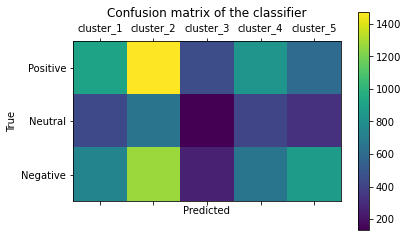

In [60]:

label_1 = ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
label_2 = ['Positive', 'Neutral', 'Negative']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(res).transpose())
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + label_1)
ax.set_yticklabels([''] + label_2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [61]:
#df_test['tokenized'] = df_test['Text'].apply(preprocess_text)

In [62]:
#voc_1000 = make_vocabulary(df_test["tokenized"])

In [63]:
#doc_freq = doc_frequency(df_test["tokenized"])

In [64]:
#sparse_tfidf_matrix = []
#for i in range(len(df_test)):
#    sparse_tfidf_matrix.append(make_tfidf_sparse(df_test['tokenized'][i], voc_1000, doc_freq, 10))

In [65]:
#jai mes vectors sparse dans mon plan
#jajoute mes centroids de maniere random et qui prennent tous trois des valeurs de vecteurs sparse. 
#loop:
#    jassigne chacun des vecteurs à leur centroids le plus proche
#    je réajuste les centroids comme la moyenne des vectuers qui leur sont associés
#    si le tableau d'assignation des vecteurs aux centroids est constant entre deux etapes, break

In [66]:
## Question 3 - Comparing classifiers

In [67]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

whole_df = pd.read_csv('/home/sebastien/Documents/Glasgow/Semester2/Text_As_Data/coursework/archive/Reviews.csv')
df = whole_df[:10000]
#shuffled_reviews = random.sample(df, k=len(df))

df.drop(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1, inplace=True)
df.loc[df['Score'] == 1, 'Sentiment'] = 'Negative'
df.loc[df['Score'] == 2, 'Sentiment'] = 'Negative'
df.loc[df['Score'] == 3, 'Sentiment'] = 'Neutral'
df.loc[df['Score'] == 4, 'Sentiment'] = 'Positive'
df.loc[df['Score'] == 5, 'Sentiment'] = 'Positive'

train_frac = 0.6
validation_frac= 0.8
split_idx = int(train_frac * len(df))
split_idxx = int(validation_frac * len(df))
train_reviews = df[:split_idx]
validation_reviews = df[split_idx:split_idxx]

In [73]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_reviews.Text, train_reviews.Sentiment, test_size=0.25, random_state=42)

# Instantiate the dummy classifier with strategy="most_frequent"
dummy = DummyClassifier(strategy="most_frequent")

# Train the classifier on the training data
dummy.fit(X_train, y_train)

# Use the classifier to predict the labels for the testing data
y_pred = dummy.predict(X_test)
 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.77
Precision: 0.26
Recall: 0.33
F1-score: 0.29


In [74]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_reviews.Text, train_reviews.Sentiment, test_size=0.25, random_state=42)

# Instantiate the dummy classifier with strategy="stratified"
dummy = DummyClassifier(strategy="stratified")

# Train the classifier on the training data
dummy.fit(X_train, y_train)

# Use the classifier to predict the labels for the testing data
y_pred = dummy.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.62
Precision: 0.34
Recall: 0.34
F1-score: 0.34


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_reviews.Text, train_reviews.Sentiment, test_size=0.25, random_state=42)

# One-hot encode the features
one_hot_encoder = OneHotEncoder(sparse=False)
X_train_one_hot = one_hot_encoder.fit_transform(X_train)
X_test_one_hot = one_hot_encoder.transform(X_test)

# Instantiate a LogisticRegression model
logistic_reg = LogisticRegression(random_state=42)

# Train the model on the one-hot encoded training data
logistic_reg.fit(X_train_one_hot, y_train)

# Use the trained model to predict the labels for the testing data
y_pred = logistic_reg.predict(X_test_one_hot)

# Evaluate the performance of the model using suitable metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

ValueError: Expected 2D array, got 1D array instead:
array=["I've always wanted to like coconut water - low in calories, high in minerals - but I've just never liked the taste much. The pineapple juice in this really makes a difference. It still needs to be well chilled to be good, but it makes a healthy post-workout drink."
 'I am giving this two stars as my family didnt mind the taste but the texture was so grainy and the biscuts fell apart easily. I was not a fan of the pancakes at all I believe they really didnt have a good flavor. Will not be wasting my money on such a tiny package either when you can but a bigger package of regular mix for less? Not fair to us with allergies in my opinion!!'
 "These are so nice and creamy!  Usually I don't justify buying k-cups for things like cocoa that you can get cheaper in a packet, but this is so convenient and very good tasting .. way better than most powdered cocoa packets I've tried.  As far as price comparison, it is equivalent to gourmet-types of cocoa that would easily cost $1+ per packet.  I also like that it comes in a variety pack with 3 flavor options.  Highly recommend"
 ...
 "Enjoyed the product and they also provided very fast shipping.  I'm about out and need to order more."
 "We love the Earth's Best line in our house. Our 9 mo old daughter  will ONLY eat Earth's Best dinners, and I don't blame her. The smell from both of the other 2 brand was nauseating. I've sampled the Earth's best dinners myself, and they aren't half bad... It is baby food.... The fruit blends and veggie blends are great as well."
 'The chocolate on the stick was all melted and all the sticks were stuck with oneanother. The product and the concept is good but you will be better off buying it from a supermarket or directly get it from someone visiting Japan.'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_reviews.Text, train_reviews.Sentiment, test_size=0.25, random_state=42)

# TF-IDF vectorize the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Instantiate a LogisticRegression model
logistic_reg = LogisticRegression(random_state=42)

# Train the model on the TF-IDF vectorized training data
logistic_reg.fit(X_train_tfidf, y_train)

# Use the trained model to predict the labels for the testing data
y_pred = logistic_reg.predict(X_test_tfidf)

# Evaluate the performance of the model using suitable metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.82
Precision: 0.66
Recall: 0.45
F1-score: 0.47


In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_reviews.Text, train_reviews.Sentiment, test_size=0.25, random_state=42)

# One-hot vectorize the text data
count_vectorizer = CountVectorizer()
X_train_one_hot = count_vectorizer.fit_transform(X_train)
X_test_one_hot = count_vectorizer.transform(X_test)

# Instantiate an SVC classifier with RBF kernel and default settings
svc = SVC(kernel='rbf')

# Train the classifier on the one-hot vectorized training data
svc.fit(X_train_one_hot, y_train)

# Use the trained classifier to predict the labels for the testing data
y_pred = svc.predict(X_test_one_hot)

# Evaluate the performance of the classifier using suitable metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.78
Precision: 0.48
Recall: 0.35
F1-score: 0.33
